## Imports

In [1]:
import torch
import os
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

In [2]:
import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'

In [3]:
%run ../jsrt.py
%run ../../utils/images.py

## Load sample image

In [17]:
from torchvision import transforms

In [4]:
images_dir = os.path.join(DATASET_DIR, 'images')
image_fpath = os.path.join(images_dir, 'JPCLN026.png')

In [8]:
tf = transforms.ToTensor()

In [19]:
image = Image.open(image_fpath).convert('L')
image = tf(image)
image.size()

torch.Size([1, 2048, 2048])

In [20]:
image.mean(), image.std()

(tensor(0.5667), tensor(0.2657))

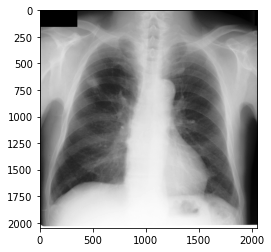

In [21]:
plt.imshow(image[0], cmap='gray')

## Split

In [89]:
import os
import random

In [95]:
%run ../jsrt.py
%run ../../utils/__init__.py

In [82]:
images_dir = os.path.join(DATASET_DIR, 'images')

metadata_fpath = os.path.join(DATASET_DIR, 'jsrt_metadata.csv')
metadata = pd.read_csv(metadata_fpath)
images = list(metadata['study_id'])
len(images), len(set(images))

(247, 247)

In [88]:
fold1 = [
    name
    for name in images
    if int(name[-5]) % 2 != 0
]
fold2 = [
    name for name in images
    if name not in train
]
len(fold1), len(fold2)

(124, 123)

In [91]:
random.shuffle(fold2)

In [94]:
n_val = len(fold2) // 2

train = fold1
val = fold2[:n_val]
test = fold2[n_val:]
len(train), len(val), len(test)

(124, 61, 62)

In [97]:
for split, images in zip(['train', 'val', 'test'], [train, val, test]):
    filepath = os.path.join(DATASET_DIR, 'splits', split)
    filepath = f'{filepath}.txt'
    write_list_to_txt(images, filepath)

## Test Dataset class

In [4]:
%run ../jsrt.py
%run ../../utils/__init__.py

In [37]:
dataset = JSRTDataset('train', image_size=(1024, 1024))
len(dataset)

124

In [6]:
item = dataset[0]

In [7]:
item.image.size()

torch.Size([1, 1024, 1024])

In [8]:
item.masks.size()

torch.Size([1024, 1024])

(-0.5, 1023.5, 1023.5, -0.5)

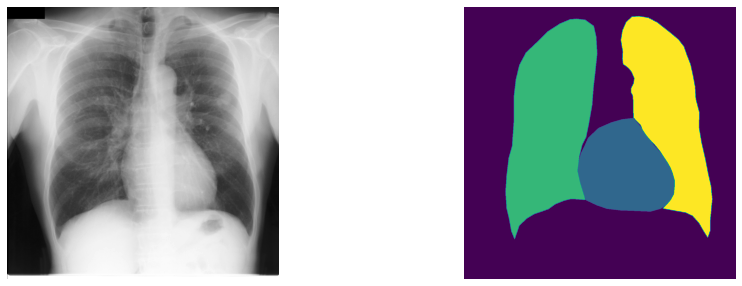

In [9]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(tensor_to_range01(item.image[0]), cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(item.masks)
plt.axis('off')

In [18]:
item.masks

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [148]:
isinstance(dataset.transform.transforms[0], transforms.Resize)

True

In [149]:
isinstance(dataset.transform.transforms[1], transforms.ToTensor)

True

In [150]:
dataset.transform.transforms

[Resize(size=(1024, 1024), interpolation=PIL.Image.BILINEAR),
 ToTensor(),
 Normalize(mean=[0.5946], std=[0.2733])]

## Debug augmentation

### Check pil-tensor bug

In [4]:
%run ../tools/augmentation.py

In [5]:
dataset = JSRTDataset('train', image_size=(1024, 1024))
len(dataset)

124

In [6]:
to_pil = transforms.ToPILImage()
to_tensor = transforms.ToTensor()

#### Check one example

In [11]:
item = dataset[0]
image = item.image
image.size()

torch.Size([1, 1024, 1024])

In [12]:
pil_image = to_pil(image)
image2 = to_tensor(pil_image)
image2.size(), pil_image.size

(torch.Size([1, 1024, 1024]), (1024, 1024))

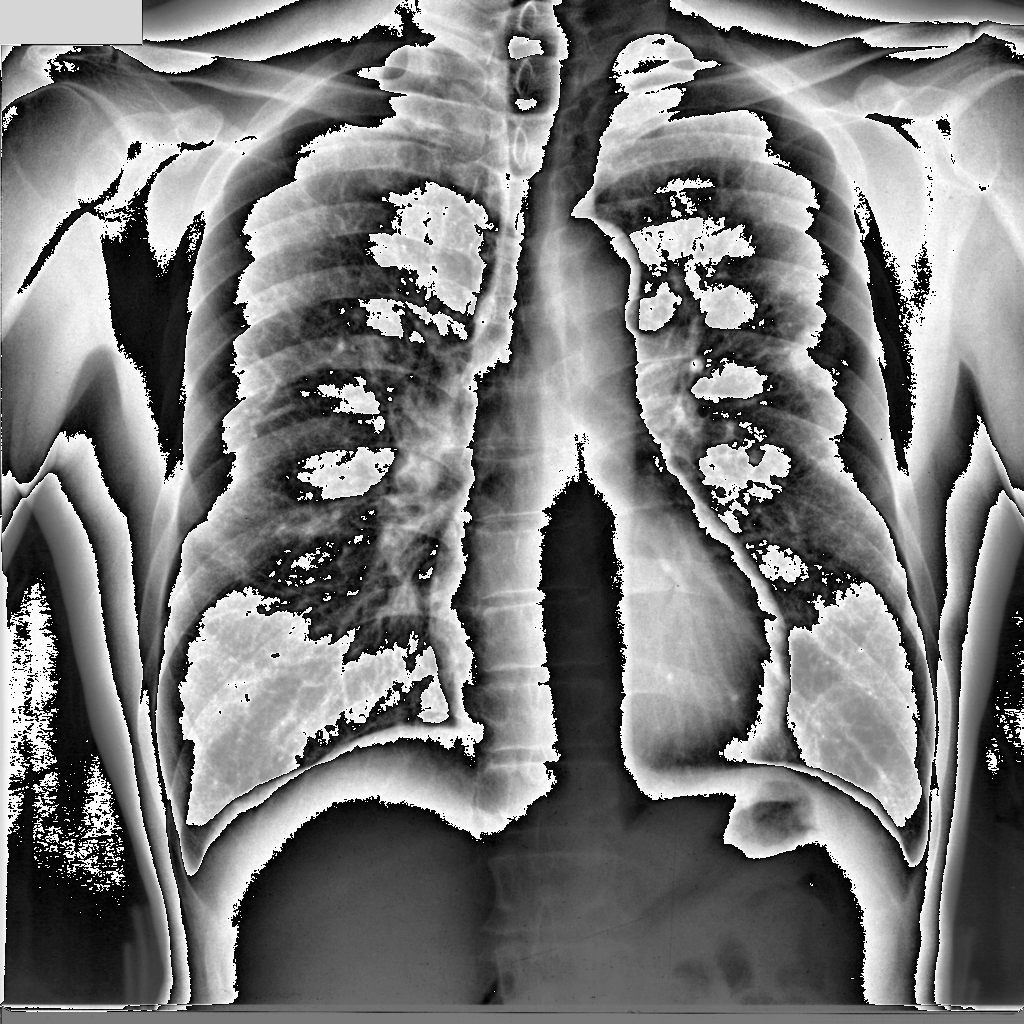

In [13]:
pil_image

In [13]:
image.min(), image.max(), image2.min(), image2.max()

(tensor(-2.1756), tensor(1.4834), tensor(0.0039), tensor(0.9961))

(-0.5, 1023.5, 1023.5, -0.5)

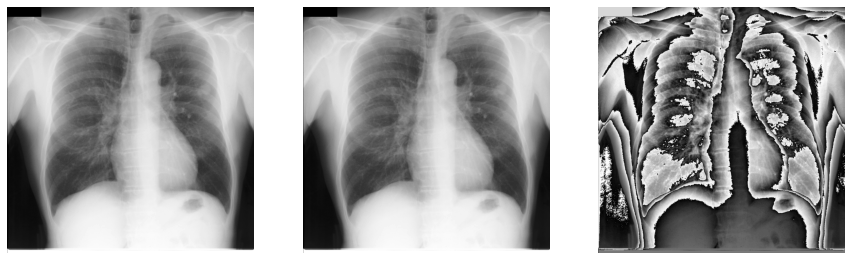

In [22]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(image[0], cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(tensor_to_range01(image[0]), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(image2[0], cmap='gray')
plt.axis('off')

#### Check multiple

In [7]:
%run ../tools/augmentation.py

In [8]:
dataset = JSRTDataset('train', image_size=(1024, 1024))
len(dataset)

124

In [9]:
aug = Augmentator(dataset, dont_shuffle=True)
len(aug)

	Augmenting all samples:  new-total=744 original=124


744

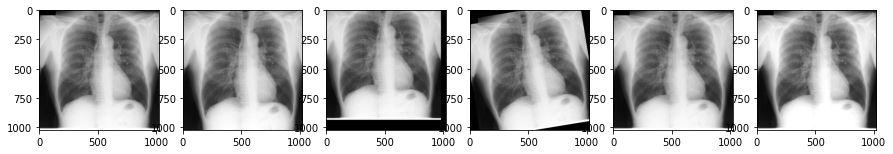

In [14]:
idx = 0
n_methods = 5

plt.figure(figsize=(15, 5))
plt.subplot(1, n_methods + 1, 1)
plt.imshow(aug[idx].image[0], cmap='gray')

for i in range(n_methods):
    plt.subplot(1, n_methods + 1, i + 2)
    plt.imshow(aug[idx + 1 + i].image[0], cmap='gray')

### Debug augmenting seg masks

In [77]:
%run ../common.py
%run ../../utils/__init__.py

In [78]:
%run ../tools/augmentation.py

In [79]:
dataset = JSRTDataset('train', image_size=(1024, 1024))
len(dataset)

124

In [80]:
aug = Augmentator(dataset, dont_shuffle=True, seg_mask=True)
len(aug)

	Augmenting all samples:  new-total=868 original=124


868

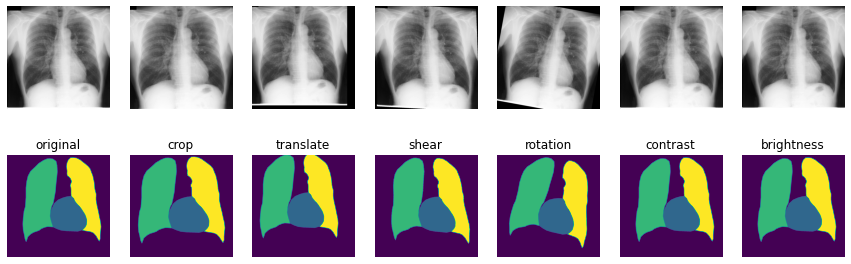

In [84]:
idx = 0
n_methods = len(aug._aug_fns)
n_cols = n_methods + 1

plt.figure(figsize=(15, 5))

item = aug[idx]
plt.subplot(2, n_cols, 1)
plt.imshow(item.image[0], cmap='gray')
plt.axis('off')

plt.subplot(2, n_cols, n_cols + 1)
plt.title('original')
plt.imshow(item.masks)
plt.axis('off')

for i, method in enumerate(list(aug._aug_fns)):
    item = aug[idx + 1 + i]
    plt.subplot(2, n_cols, i + 2)
    plt.imshow(item.image[0], cmap='gray')
    plt.axis('off')
    
    plt.subplot(2, n_cols, n_cols + i + 2)
    plt.title(method)
    plt.imshow(item.masks)
    plt.axis('off')

In [14]:
masks1 = aug[10].masks
masks2 = aug[11].masks
print(masks1.min(), masks1.max(), masks1.type(), masks1.size())
print(masks2.min(), masks2.max(), masks2.type(), masks2.size())

tensor(0) tensor(3) torch.LongTensor torch.Size([1024, 1024])
tensor(0) tensor(3) torch.LongTensor torch.Size([1024, 1024])


## Compute mean and std

In [22]:
import os
import pandas as pd

In [23]:
%run ../jsrt.py
%run ../../utils/images.py

In [25]:
images_dir = os.path.join(DATASET_DIR, 'images')

# metadata_fpath = os.path.join(DATASET_DIR, 'jsrt_metadata.csv')
# metadata = pd.read_csv(metadata_fpath)

# image_names = metadata['study_id']

In [26]:
fpath = os.path.join(DATASET_DIR, 'splits', 'train.txt')
with open(fpath) as f:
    image_names = [l.strip() for l in f.readlines()]
len(image_names)

124

In [30]:
iterator = ImageFolderIterator(images_dir, image_names, image_format='L')
mean, std = compute_mean_std(iterator, show=True, n_channels=1)
mean, std

(tensor([0.5946]), tensor([0.2733]))

## Check image sizes

In [ ]:
import matplotlib.pyplot as plt

In [24]:
# idx = 2
# image_name = dataset.images_names[idx]

sizes = set()

for image_name in dataset.images_names:
    image_fpath = os.path.join(dataset.images_dir, image_name)

    image = Image.open(image_fpath).convert('RGB')
    sizes.add(image.size)
    
sizes

{(2048, 2048)}

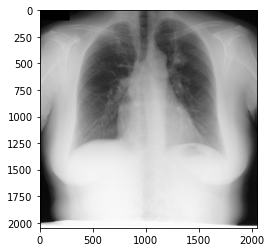

In [23]:
plt.imshow(image)

All images are 2048 x 2048

## Compute class balance

In [24]:
from collections import Counter
from tqdm.notebook import tqdm

In [4]:
images_dir = os.path.join(DATASET_DIR, 'images')

image_names = os.listdir(images_dir)
len(image_names)

247

In [10]:
dataset = JSRTDataset('all')
len(dataset)

247

In [14]:
n_labels = len(dataset.seg_labels)

In [25]:
counts = Counter()

for image_name in tqdm(image_names):
    masks = dataset.get_masks(image_name)
    
    counts += Counter(t.item() for t in masks.view(-1))
    
counts

Counter({0: 38687414, 2: 11115892, 3: 9068420, 1: 5877842})

In [27]:
height, width = masks.size()
total = height * width * len(image_names)

for i_label in range(n_labels):
    amount = counts[i_label] / total * 100
    print(f'Label: {i_label}, {amount:.1f}%')

Label: 0, 59.7%
Label: 1, 9.1%
Label: 2, 17.2%
Label: 3, 14.0%
